## Positional Embedding
[Source](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/
)
- we can use the positional embedding to encode the position of each word in the sentence
- Suppose we have a sequence of Length $L$.
  
Sine part of the positional embedding
$$
    P(K,2i) = \sin(\frac{K}{n^{2i/d}})
$$

Cosine part of the positional embedding
$$
    P(K,2i+1) = \cos(\frac{K}{n^{2i/d}})
$$

+ K : position of the word in the sentence, $ 0 \leq K < L$
+ d : dimension of the embedding space
+ n : User-defined Constant, set to $10000$ according to the paper
+ P(K, j) : position function to map the position of the word in a sentence to the embedding space
+ i : used for mapping to the embedding space. $0 \leq i < d/2$


In [5]:
import torch 
import math

class SinsoidalPostionalEmbedding(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, sequence):
        d = self.dim // 2
        n = math.log(10000) / (d - 1 + 1e-8) #* n
        
        #* d^(-n) where d = 0, 1, 2, ..., d-1
        #* tensor of shape (d,)
        embedding = torch.exp(torch.arange(d, device=sequence.device) * -n) 
        embedding = sequence[:, None] * embedding[None, :] #* (seq_len, d)
        
        #* sin(embedding) and cos(embedding), then concat them
        embedding = torch.cat((embedding.sin(), embedding.cos()), dim=-1) #* (seq_len, 2d)
        
        return embedding
    
embed = SinsoidalPostionalEmbedding(4)
sequence = torch.arange(4)
embed(sequence)
        

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  1.0000e-04,  5.4030e-01,  1.0000e+00],
        [ 9.0930e-01,  2.0000e-04, -4.1615e-01,  1.0000e+00],
        [ 1.4112e-01,  3.0000e-04, -9.8999e-01,  1.0000e+00]])

In [2]:
sequence 

tensor([0, 1, 2, 3])

In [37]:
k = torch.arange(4).expand(4, 4).t() # Lx D
k

RuntimeError: The expanded size of the tensor (5) must match the existing size (4) at non-singleton dimension 1.  Target sizes: [4, 5].  Tensor sizes: [4]

In [25]:
k[:, 0::4]

tensor([[ 0.4051, -1.1307],
        [-0.3020,  0.0926],
        [-0.0175,  0.3984],
        [-1.1897, -0.2188],
        [-0.1612, -1.0406],
        [-1.1341, -0.7882],
        [-0.8459,  0.0887],
        [ 0.2145, -0.2078]])

In [47]:
import numpy as np
import matplotlib.pyplot as plt


sequance  = ['I', 'am', 'a', 'student']
word2idx = {'I':0, 'am':1, 'a':2, 'student':3}
n = 100
L =len(word2idx)
L = 5
d = 4

In [53]:
embedding_space = np.zeros(shape=(L, d))
for K in range(L):
    for i in range(int(d/2)):
        demonirator = np.power(n, 2*i/d)   #* 100^(2i/d)
        embedding_space[K, 2*i] = np.sin(K/demonirator)
        embedding_space[K, 2*i+1] = np.cos(K/(10000**(2*i/d)))
        
embedding_space #* (L, d)

array([[ 0.        ,  1.        ,  0.        ,  1.        ],
       [ 0.84147098,  0.54030231,  0.09983342,  0.99995   ],
       [ 0.90929743, -0.41614684,  0.19866933,  0.99980001],
       [ 0.14112001, -0.9899925 ,  0.29552021,  0.99955003],
       [-0.7568025 , -0.65364362,  0.38941834,  0.99920011]])

In [39]:
def get_postional_encodings(seq_len, d, n=10000):
    P = np.zeros(shape=(seq_len, d))
    for pos in range(seq_len):
        for i in range(int(d/2)):
            denominator = np.power(n, 2*i/d) #* 2i/d is the dimension of the positional encoding
            P[pos, 2*i] = np.sin(pos/denominator)
            P[pos, 2*i+1] = np.cos(pos/denominator)
    return P

p = get_postional_encodings(len(sequance), d, n)
p
            

array([[ 0.        ,  1.        ,  0.        ,  1.        ],
       [ 0.84147098,  0.54030231,  0.09983342,  0.99500417],
       [ 0.90929743, -0.41614684,  0.19866933,  0.98006658],
       [ 0.14112001, -0.9899925 ,  0.29552021,  0.95533649]])

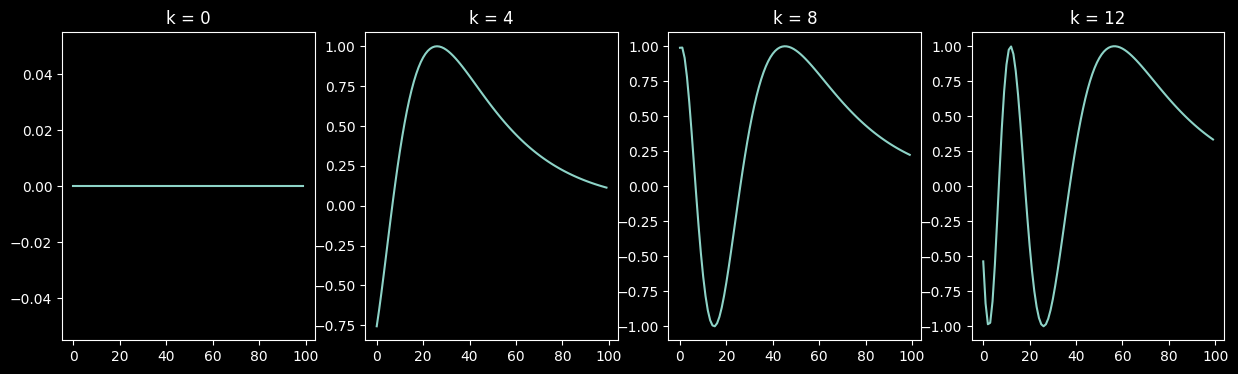

In [40]:
def plotSinusoid(k, d=512, n=10000):
    x = np.arange(0, 100, 1)
    denominator = np.power(n, 2*x/d)
    y = np.sin(k/denominator)
    plt.plot(x, y)
    plt.title('k = ' + str(k))

fig = plt.figure(figsize=(15, 4))    
for i in range(4):
    plt.subplot(141 + i)
    plotSinusoid(i*4)

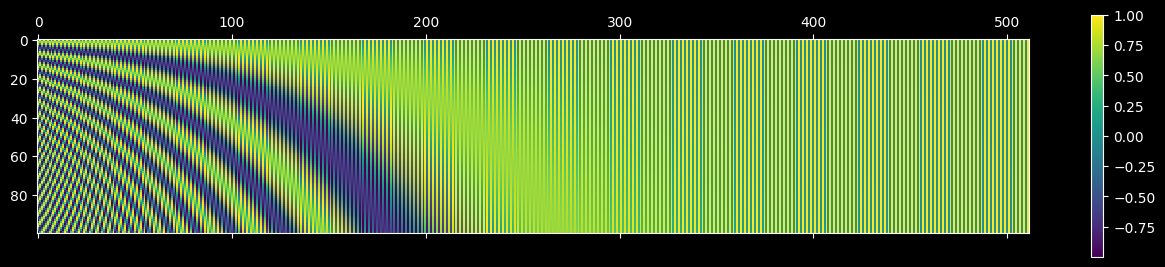

In [42]:
P = get_postional_encodings(seq_len=100, d=512, n=10000)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

## Positional embedding in pytorch
- let dim = 4 (dimension of the embedding)
- let T = 4 (number of timesteps)


- $ d = \frac{dim}{2} = 4$
- $ drange = {x : 0, 1, ..., d}$

the positional embedding is defined as
$$
    n = \frac{\log_2{10000}}{d-1}
$$

$$ 
    R = \exp{^{drainge * -n}} , shape = (d)
$$


$$
    Pos = T * R , shape = (T, R)
$$ 

$$
    Pos = [Cos(Pos), Sin(Pos)], shape = (T, dim)

$$

In [7]:
from torch import nn
import torch
import math
class SinsoidalPositionalEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, timestep): 
        #* get the device of the timestep
        device = timestep.device 
        
        #* get the half of the dimension
        half_dim = self.dim // 2 
        
        #* calculate the frequency #* 2^i / 10000^(2i/d)
        embeddings = math.log(10000) / (half_dim - 1+1e-6) #* 1e-6 is added to avoid division by zero
        
        #* calculate the embeddings
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings) 
        embeddings = timestep[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        
        return embeddings

        

In [8]:
pos_embedding = SinsoidalPositionalEmbeddings(4)
timestep = torch.arange(4)
pos_embedding(timestep)

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  1.0000e-04,  5.4030e-01,  1.0000e+00],
        [ 9.0930e-01,  2.0000e-04, -4.1615e-01,  1.0000e+00],
        [ 1.4112e-01,  3.0000e-04, -9.8999e-01,  1.0000e+00]])